## Himanshu, MDS202327

#### Installing required packages

In [0]:
%%capture
%pip install pydeequ

In [0]:
# Importing the libraries
import pandas as pd
from pyspark.sql import SparkSession
import pydeequ
from pydeequ.analyzers import *
from pydeequ.checks import *
from pydeequ.verification import *
from pydeequ.suggestions import *

#### Read the data using pandas

In [0]:
df = pd.read_csv("https://www.cmi.ac.in/~himanshu680.mds2023/data/adult.csv")

#### Initialize the Spark session

In [0]:
# Initialize Spark session
spark = (
    SparkSession.builder
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate()
)


#### Read the data frame into spark

In [0]:
df_deequ = spark.createDataFrame(df)
df_deequ.show()

+---+-----------------+------+-------------+---+--------------------+------------------+--------------+-------------------+-------+-----+---+---+--------------+------+
| 39|        State-gov| 77516|    Bachelors| 13|       Never-married|      Adm-clerical| Not-in-family|              White|   Male| 2174|  0| 40| United-States| <=50K|
+---+-----------------+------+-------------+---+--------------------+------------------+--------------+-------------------+-------+-----+---+---+--------------+------+
| 50| Self-emp-not-inc| 83311|    Bachelors| 13|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|    0|  0| 13| United-States| <=50K|
| 38|          Private|215646|      HS-grad|  9|            Divorced| Handlers-cleaners| Not-in-family|              White|   Male|    0|  0| 40| United-States| <=50K|
| 53|          Private|234721|         11th|  7|  Married-civ-spouse| Handlers-cleaners|       Husband|              Black|   Male|    0|  0| 40| United-States|

#### Schema of the data frame

In [0]:
df_deequ.printSchema()

root
 |-- 39: long (nullable = true)
 |--  State-gov: string (nullable = true)
 |--  77516: long (nullable = true)
 |--  Bachelors: string (nullable = true)
 |--  13: long (nullable = true)
 |--  Never-married: string (nullable = true)
 |--  Adm-clerical: string (nullable = true)
 |--  Not-in-family: string (nullable = true)
 |--  White: string (nullable = true)
 |--  Male: string (nullable = true)
 |--  2174: long (nullable = true)
 |--  0: long (nullable = true)
 |--  40: long (nullable = true)
 |--  United-States: string (nullable = true)
 |--  <=50K: string (nullable = true)



In [0]:
schema_columns = [field.name for field in df_deequ.schema.fields]
print("Column names:", schema_columns)

Column names: ['39', ' State-gov', ' 77516', ' Bachelors', ' 13', ' Never-married', ' Adm-clerical', ' Not-in-family', ' White', ' Male', ' 2174', ' 0', ' 40', ' United-States', ' <=50K']


The schema shows that the column names are not properly formatted - they appear to be the actual data values from the first row. This suggests the CSV file was read without headers or the headers weren't properly processed. The columns appear to represent the Adult Census Income dataset.

#### Rename Columns for Better Analysis

In [0]:
# Define proper column names based on the Adult dataset standard names
proper_column_names = ["age", "workclass", "fnlwgt", "education", "education_num", 
                       "marital_status", "occupation", "relationship", "race", 
                       "sex", "capital_gain", "capital_loss", "hours_per_week", 
                       "native_country", "income"]

# Create a new DataFrame with proper column names
df_deequ = df_deequ.toDF(*proper_column_names)

# Show the renamed DataFrame
df_deequ.show(5)

+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| 50| Self-emp-not-inc| 83311| Bachelors|           13| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|           0|           0|            13| United-States| <=50K|
| 38|          Private|215646|   HS-grad|            9|           Divorced| Handlers-cleaners| Not-in-family| White|   Male|           0|           0|            40| United-States| <=50K|
| 53|          Private|234721|      11th|            7| Marr

#### Check for Duplicate Rows


In [0]:
# Check for duplicate rows in the DataFrame
duplicate_count = df_deequ.groupBy(df_deequ.columns).count().filter("count > 1").count()
print(f"Number of duplicate rows: {duplicate_count}")

# If duplicates exist, you can view them
if duplicate_count > 0:
    print("Sample of duplicate rows:")
    df_deequ.groupBy(df_deequ.columns).count().filter("count > 1").show(5)


Number of duplicate rows: 23
Sample of duplicate rows:
+---+---------+------+-------------+-------------+-------------------+---------------+--------------+------+-------+------------+------------+--------------+--------------+------+-----+
|age|workclass|fnlwgt|    education|education_num|     marital_status|     occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|count|
+---+---------+------+-------------+-------------+-------------------+---------------+--------------+------+-------+------------+------------+--------------+--------------+------+-----+
| 46|  Private|133616| Some-college|           10|           Divorced|   Adm-clerical|     Unmarried| White| Female|           0|           0|            40| United-States| <=50K|    2|
| 42|  Private|204235| Some-college|           10| Married-civ-spouse| Prof-specialty|       Husband| White|   Male|           0|           0|            40| United-States|  >50K|    2|
| 35|  Private|

#### Remove the duplicated rows

In [0]:
# Step 1: Check the number of rows before removing duplicates
original_count = df_deequ.count()
print(f"Original number of rows: {original_count}")

# Step 2: Identify duplicate rows
# First, let's see how many duplicates we have
duplicate_count = df_deequ.groupBy(df_deequ.columns).count().filter("count > 1").count()
print(f"Number of duplicate row patterns: {duplicate_count}")

# Optional: View some examples of the duplicated rows
print("Examples of duplicate rows:")
duplicates = df_deequ.groupBy(df_deequ.columns).count().filter("count > 1")
duplicates.show(5, truncate=False)

# Step 3: Remove duplicates and create a new DataFrame
df_deduped = df_deequ.dropDuplicates()

# Step 4: Check the number of rows after removing duplicates
deduped_count = df_deduped.count()
print(f"Number of rows after removing duplicates: {deduped_count}")
print(f"Number of duplicate rows removed: {original_count - deduped_count}")

# Step 5: Verify that no duplicates remain
remaining_dupes = df_deduped.groupBy(df_deduped.columns).count().filter("count > 1").count()
print(f"Remaining duplicate patterns after deduplication: {remaining_dupes}")

Original number of rows: 32560
Number of duplicate row patterns: 23
Examples of duplicate rows:
+---+---------+------+-------------+-------------+-------------------+---------------+--------------+------+-------+------------+------------+--------------+--------------+------+-----+
|age|workclass|fnlwgt|education    |education_num|marital_status     |occupation     |relationship  |race  |sex    |capital_gain|capital_loss|hours_per_week|native_country|income|count|
+---+---------+------+-------------+-------------+-------------------+---------------+--------------+------+-------+------------+------------+--------------+--------------+------+-----+
|46 | Private |133616| Some-college|10           | Divorced          | Adm-clerical  | Unmarried    | White| Female|0           |0           |40            | United-States| <=50K|2    |
|42 | Private |204235| Some-college|10           | Married-civ-spouse| Prof-specialty| Husband      | White| Male  |0           |0           |40            | Un

In [0]:
# Use the deduplicated DataFrame for further analysis
df_deequ = df_deduped

#### Run Basic Data Profiling with Proper Column Names

In [0]:
# Run analysis for basic profiling with proper column names
analysis_result = AnalysisRunner(spark) \
    .onData(df_deequ) \
    .addAnalyzer(Size()) \
    .addAnalyzer(Completeness("*")) \
    .addAnalyzer(Mean("age")) \
    .addAnalyzer(Mean("education_num")) \
    .addAnalyzer(Mean("hours_per_week")) \
    .addAnalyzer(Minimum("age")) \
    .addAnalyzer(Maximum("age")) \
    .addAnalyzer(StandardDeviation("age")) \
    .run()

# Convert results to DataFrame and display
analysis_result_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysis_result)
analysis_result_df.show(truncate=False)


+-------+--------------+-----------------+------------------+
|entity |instance      |name             |value             |
+-------+--------------+-----------------+------------------+
|Column |age           |Minimum          |17.0              |
|Column |age           |Maximum          |90.0              |
|Dataset|*             |Size             |32536.0           |
|Column |hours_per_week|Mean             |40.440343004671746|
|Column |education_num |Mean             |10.081724858618147|
|Column |age           |Mean             |38.58553602163757 |
|Column |age           |StandardDeviation|13.637983324909587|
+-------+--------------+-----------------+------------------+



/databricks/spark/python/pyspark/sql/dataframe.py:159: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


#### Analyze Categorical Columns

In [0]:
# Analyze categorical columns
from pydeequ.analyzers import Distinctness, Uniqueness, UniqueValueRatio

categorical_columns = ["workclass", "education", "marital_status", "occupation", 
                       "relationship", "race", "sex", "native_country", "income"]

categorical_analysis = AnalysisRunner(spark) \
    .onData(df_deequ) \
    .addAnalyzer(Distinctness(categorical_columns)) \
    .run()

categorical_results = AnalyzerContext.successMetricsAsDataFrame(spark, categorical_analysis)
categorical_results.show(truncate=False)

# Count distribution of values in categorical columns
for column in categorical_columns:
    print(f"\nDistribution of {column}:")
    df_deequ.groupBy(column).count().orderBy("count", ascending=False).show(10)


+-----------+-----------------------------------------------------------------------------------------+------------+------------------+
|entity     |instance                                                                                 |name        |value             |
+-----------+-----------------------------------------------------------------------------------------+------------+------------------+
|Multicolumn|workclass,education,marital_status,occupation,relationship,race,sex,native_country,income|Distinctness|0.2964716006884682|
+-----------+-----------------------------------------------------------------------------------------+------------+------------------+


Distribution of workclass:
+-----------------+-----+
|        workclass|count|
+-----------------+-----+
|          Private|22673|
| Self-emp-not-inc| 2540|
|        Local-gov| 2093|
|                ?| 1836|
|        State-gov| 1297|
|     Self-emp-inc| 1116|
|      Federal-gov|  960|
|      Without-pay|   14|
|    

#### Perform Meaningful Data Quality Checks


In [0]:
# Define checks based on your actual data
check = Check(spark, CheckLevel.Warning, "Adult Census Data Quality Check")

checkResult = VerificationSuite(spark) \
    .onData(df_deequ) \
    .addCheck(
        check.hasSize(lambda x: x >= 1000)  # Ensure dataset has sufficient size
        .isComplete("age")  # Check age is complete
        .isComplete("income")  # Check income is complete
        .isContainedIn("income", ["<=50K", ">50K"])  # Check income values
        .isNonNegative("age")  # Age should be non-negative
        .isNonNegative("hours_per_week")  # Working hours should be non-negative
        .hasMin("age", lambda x: x >= 16)  # Minimum working age
        .hasMax("age", lambda x: x <= 100)  # Maximum reasonable age
        .hasMax("hours_per_week", lambda x: x <= 168)  # Maximum hours in a week
        .isContainedIn("sex", ["Male", "Female"])  # Check sex values
    ) \
    .run()

# Convert results to DataFrame and display
checkResult_df = VerificationResult.checkResultsAsDataFrame(spark, checkResult)
checkResult_df.show(truncate=False)


+-------------------------------+-----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------------------------------------------------+
|check                          |check_level|check_status|constraint                                                                                                                                                |constraint_status|constraint_message                                  |
+-------------------------------+-----------+------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------------------------------------------------+
|Adult Census Data Quality Check|Warning    |Warning     |SizeConstraint(Size(None))                                                             

#### Analyze Missing Values and Anomalies


In [0]:
from pyspark.sql.functions import col, min, max, mean, stddev, count, when, lit

# Check for missing values or placeholders (like '?')
for column in proper_column_names:
    missing_count = df_deequ.filter(df_deequ[column].isNull() | (df_deequ[column] == "?")).count()
    total_count = df_deequ.count()
    missing_percentage = (missing_count / total_count) * 100
    print(f"Column {column}: {missing_count} missing values ({missing_percentage:.2f}%)")

# Check for potential outliers in numerical columns
numerical_columns = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

# Function to safely cast to double
def safe_cast(column_name):
    return col(column_name).cast("double")

# Calculate statistics for numerical columns
for column in numerical_columns:
    stats = df_deequ.select(
        count(col(column)).alias("count"),
        min(safe_cast(column)).alias("min"),
        max(safe_cast(column)).alias("max"),
        mean(safe_cast(column)).alias("mean"),
        stddev(safe_cast(column)).alias("stddev"),
        count(when(safe_cast(column) > 0, lit(1))).alias("non_zero_count")
    ).collect()[0]
    
    print(f"\nStatistics for {column}:")
    print(f"Count: {stats['count']}")
    print(f"Min: {stats['min']}")
    print(f"Max: {stats['max']}")
    print(f"Mean: {stats['mean']}")
    print(f"StdDev: {stats['stddev']}")
    print(f"Non-zero count: {stats['non_zero_count']}")

# For a more detailed view of each column
print("\nDetailed summary for all numerical columns:")
df_deequ.select(*numerical_columns).summary().show()


Column age: 0 missing values (0.00%)
Column workclass: 0 missing values (0.00%)
Column fnlwgt: 0 missing values (0.00%)
Column education: 0 missing values (0.00%)
Column education_num: 0 missing values (0.00%)
Column marital_status: 0 missing values (0.00%)
Column occupation: 0 missing values (0.00%)
Column relationship: 0 missing values (0.00%)
Column race: 0 missing values (0.00%)
Column sex: 0 missing values (0.00%)
Column capital_gain: 0 missing values (0.00%)
Column capital_loss: 0 missing values (0.00%)
Column hours_per_week: 0 missing values (0.00%)
Column native_country: 0 missing values (0.00%)
Column income: 0 missing values (0.00%)

Statistics for age:
Count: 32536
Min: 17.0
Max: 90.0
Mean: 38.58553602163757
StdDev: 13.638192912715516
Non-zero count: 32536

Statistics for fnlwgt:
Count: 32536
Min: 12285.0
Max: 1484705.0
Mean: 189784.2989918859
StdDev: 105556.2582113857
Non-zero count: 32536

Statistics for education_num:
Count: 32536
Min: 1.0
Max: 16.0
Mean: 10.0817248586181

In [0]:
# Generate suggestions for data quality checks
suggestion_result = ConstraintSuggestionRunner(spark) \
    .onData(df_deequ) \
    .addConstraintRule(DEFAULT()) \
    .run()

# Print the suggestions
for suggestion in suggestion_result["constraint_suggestions"]:
    print(f'Constraint suggestion for column: {suggestion["column_name"]}')
    print(f'Description: {suggestion["description"]}')
    print(f'Constraint code: {suggestion["code_for_constraint"]}')
    print("---")


Constraint suggestion for column: marital_status
Description: 'marital_status' has value range ' Married-civ-spouse', ' Never-married', ' Divorced', ' Separated', ' Widowed', ' Married-spouse-absent', ' Married-AF-spouse'
Constraint code: .isContainedIn("marital_status", [" Married-civ-spouse", " Never-married", " Divorced", " Separated", " Widowed", " Married-spouse-absent", " Married-AF-spouse"])
---
Constraint suggestion for column: marital_status
Description: 'marital_status' is not null
Constraint code: .isComplete("marital_status")
---
Constraint suggestion for column: marital_status
Description: 'marital_status' has value range ' Married-civ-spouse', ' Never-married', ' Divorced' for at least 92.0% of values
Constraint code: .isContainedIn("marital_status", [" Married-civ-spouse", " Never-married", " Divorced"], lambda x: x >= 0.92, "It should be above 0.92!")
---
Constraint suggestion for column: education_num
Description: 'education_num' has value range '9', '10', '13', '14', 

#### Analyze Correlations Between Features


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Correlation Matrix:
                     age  education_num  ...  capital_loss  hours_per_week
age             1.000000       0.036224  ...      0.057745        0.068515
education_num   0.036224       1.000000  ...      0.079901        0.148426
capital_gain    0.077676       0.122661  ...     -0.031638        0.078408
capital_loss    0.057745       0.079901  ...      1.000000        0.054229
hours_per_week  0.068515       0.148426  ...      0.054229        1.000000

[5 rows x 5 columns]


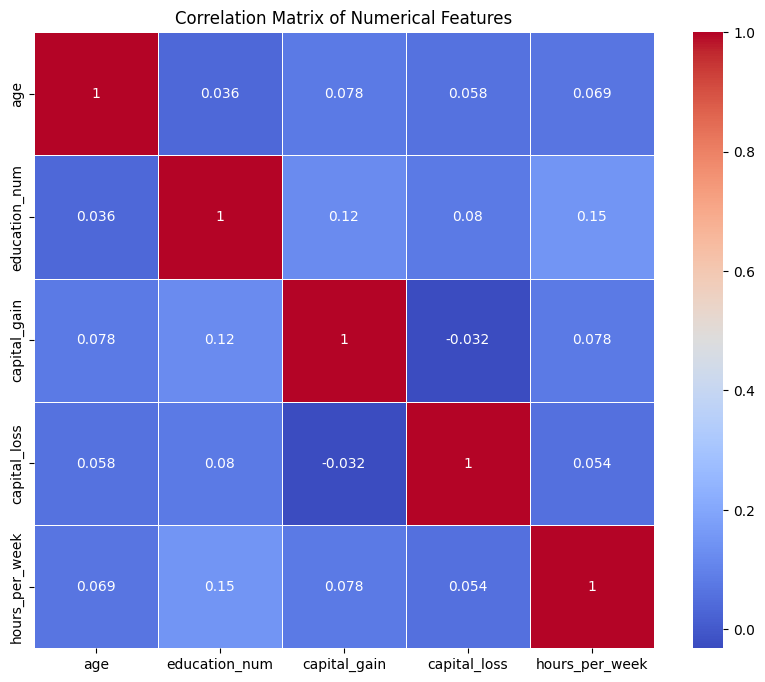

In [0]:
# Select numerical columns
numerical_df = df_deequ.select("age", "education_num", "capital_gain", "capital_loss", "hours_per_week")

# Assemble features into a vector
assembler = VectorAssembler(inputCols=numerical_df.columns, outputCol="features")
vector_df = assembler.transform(numerical_df).select("features")

# Calculate correlation matrix
matrix = Correlation.corr(vector_df, "features").collect()[0][0]
correlation_matrix = matrix.toArray().tolist()

# Convert to pandas DataFrame for visualization
pdf_corr = pd.DataFrame(data=correlation_matrix, columns=numerical_df.columns, index=numerical_df.columns)

# Display correlation matrix
print("Correlation Matrix:")
print(pdf_corr)

# Visualization of the plot
plt.figure(figsize=(10, 8))
sns.heatmap(pdf_corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


#### Analyze Income Distribution by Features


In [0]:
# Analyze income distribution by categorical features
categorical_features = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"]

for feature in categorical_features:
    print(f"\nIncome distribution by {feature}:")
    df_deequ.groupBy(feature, "income") \
        .count() \
        .orderBy(feature, "income") \
        .show(truncate=False)
    
    # Calculate percentage of high income by feature
    income_by_feature = df_deequ.groupBy(feature, "income").count()
    feature_totals = income_by_feature.groupBy(feature).sum("count").withColumnRenamed("sum(count)", "total")
    
    high_income = income_by_feature.filter(income_by_feature["income"] == ">50K") \
        .join(feature_totals, feature) \
        .withColumn("high_income_percentage", (income_by_feature["count"] / feature_totals["total"]) * 100)
    
    high_income.select(feature, "count", "total", "high_income_percentage") \
        .orderBy("high_income_percentage", ascending=False) \
        .show(truncate=False)



Income distribution by workclass:
+-----------------+------+-----+
|workclass        |income|count|
+-----------------+------+-----+
| ?               | <=50K|1645 |
| ?               | >50K |191  |
| Federal-gov     | <=50K|589  |
| Federal-gov     | >50K |371  |
| Local-gov       | <=50K|1476 |
| Local-gov       | >50K |617  |
| Never-worked    | <=50K|7    |
| Private         | <=50K|17712|
| Private         | >50K |4961 |
| Self-emp-inc    | <=50K|494  |
| Self-emp-inc    | >50K |622  |
| Self-emp-not-inc| <=50K|1816 |
| Self-emp-not-inc| >50K |724  |
| State-gov       | <=50K|944  |
| State-gov       | >50K |353  |
| Without-pay     | <=50K|14   |
+-----------------+------+-----+

+---------+-----+-----+----------------------+
|workclass|count|total|high_income_percentage|
+---------+-----+-----+----------------------+
+---------+-----+-----+----------------------+


Income distribution by education:
+-----------+------+-----+
|education  |income|count|
+-----------+------+-----+

#### Analyze Data Distribution and Outliers


In [0]:
from pyspark.sql.functions import col, expr, percentile_approx

# Calculate percentiles for numerical columns to identify outliers
percentiles = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
numerical_cols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

for column in numerical_cols:
    print(f"\nPercentiles for {column}:")
    df_deequ.select(
        percentile_approx(col(column), percentiles, 10000).alias("percentiles")
    ).select([
        expr(f"percentiles[{i}]").alias(f"p{int(p*100)}")
        for i, p in enumerate(percentiles)
    ]).show()
    
    # Identify potential outliers (values beyond 1.5 * IQR)
    stats = df_deequ.select(
        percentile_approx(col(column), [0.25, 0.75], 10000).alias("quartiles")
    ).collect()[0]["quartiles"]
    
    q1, q3 = stats[0], stats[1]
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outlier_count = df_deequ.filter(
        (col(column) < lower_bound) | (col(column) > upper_bound)
    ).count()
    
    total_count = df_deequ.count()
    outlier_percentage = (outlier_count / total_count) * 100
    
    print(f"Potential outliers in {column}: {outlier_count} ({outlier_percentage:.2f}%)")
    print(f"IQR bounds: [{lower_bound}, {upper_bound}]")
    
    # Show some examples of outliers if they exist
    if outlier_count > 0:
        print("Sample outliers:")
        df_deequ.filter(
            (col(column) < lower_bound) | (col(column) > upper_bound)
        ).select(column).distinct().show(5)



Percentiles for age:
+---+---+---+---+---+---+---+
| p1| p5|p25|p50|p75|p95|p99|
+---+---+---+---+---+---+---+
| 17| 19| 28| 37| 48| 63| 74|
+---+---+---+---+---+---+---+

Potential outliers in age: 142 (0.44%)
IQR bounds: [-2.0, 78.0]
Sample outliers:
+---+
|age|
+---+
| 79|
| 88|
| 80|
| 81|
| 82|
+---+
only showing top 5 rows


Percentiles for fnlwgt:
+-----+-----+------+------+------+------+------+
|   p1|   p5|   p25|   p50|   p75|   p95|   p99|
+-----+-----+------+------+------+------+------+
|27153|39432|117814|178353|236985|379522|509866|
+-----+-----+------+------+------+------+------+

Potential outliers in fnlwgt: 993 (3.05%)
IQR bounds: [-60942.5, 415741.5]
Sample outliers:
+------+
|fnlwgt|
+------+
|432376|
|428030|
|494223|
|446839|
|544091|
+------+
only showing top 5 rows


Percentiles for education_num:
+---+---+---+---+---+---+---+
| p1| p5|p25|p50|p75|p95|p99|
+---+---+---+---+---+---+---+
|  3|  5|  9| 10| 12| 14| 16|
+---+---+---+---+---+---+---+

Potential outli

#### Analyze Relationships Between Features


In [0]:
# Analyze relationship between education level and income
print("Income distribution by education level:")
education_income = df_deequ.groupBy("education", "income") \
    .count() \
    .orderBy("education", "income")

education_totals = education_income.groupBy("education") \
    .sum("count") \
    .withColumnRenamed("sum(count)", "total")

education_with_percentage = education_income.join(education_totals, "education") \
    .withColumn("percentage", (education_income["count"] / education_totals["total"]) * 100)

education_with_percentage.select(
    "education", "income", "count", "total", "percentage"
).orderBy("education", "income").show(30)

# Analyze relationship between age groups and income
from pyspark.sql.functions import when, floor

df_deequ = df_deequ.withColumn(
    "age_group", 
    when(col("age") < 25, "18-24")
    .when(col("age") < 35, "25-34")
    .when(col("age") < 45, "35-44")
    .when(col("age") < 55, "45-54")
    .when(col("age") < 65, "55-64")
    .otherwise("65+")
)

print("Income distribution by age group:")
age_income = df_deequ.groupBy("age_group", "income") \
    .count() \
    .orderBy("age_group", "income")

age_totals = age_income.groupBy("age_group") \
    .sum("count") \
    .withColumnRenamed("sum(count)", "total")

age_with_percentage = age_income.join(age_totals, "age_group") \
    .withColumn("percentage", (age_income["count"] / age_totals["total"]) * 100)

age_with_percentage.select(
    "age_group", "income", "count", "total", "percentage"
).orderBy("age_group", "income").show()


Income distribution by education level:
+-------------+------+-----+-----+------------------+
|    education|income|count|total|        percentage|
+-------------+------+-----+-----+------------------+
|         10th| <=50K|  871|  933| 93.35476956055734|
|         10th|  >50K|   62|  933| 6.645230439442658|
|         11th| <=50K| 1115| 1175|  94.8936170212766|
|         11th|  >50K|   60| 1175| 5.106382978723404|
|         12th| <=50K|  400|  433| 92.37875288683603|
|         12th|  >50K|   33|  433| 7.621247113163972|
|      1st-4th| <=50K|  160|  166|  96.3855421686747|
|      1st-4th|  >50K|    6|  166| 3.614457831325301|
|      5th-6th| <=50K|  316|  332| 95.18072289156626|
|      5th-6th|  >50K|   16|  332| 4.819277108433735|
|      7th-8th| <=50K|  605|  645|  93.7984496124031|
|      7th-8th|  >50K|   40|  645|   6.2015503875969|
|          9th| <=50K|  487|  514| 94.74708171206225|
|          9th|  >50K|   27|  514| 5.252918287937743|
|   Assoc-acdm| <=50K|  802| 1067| 75.1640

#### Analyze Data Quality Issues


In [0]:
from pyspark.sql.functions import isnan, when, count, col

# Check for inconsistencies in categorical columns
categorical_cols = ["workclass", "education", "marital_status", "occupation", 
                   "relationship", "race", "sex", "native_country", "income"]

for column in categorical_cols:
    print(f"\nUnique values in {column}:")
    df_deequ.select(column).distinct().show(100, truncate=False)
    
    # Check for potentially problematic values (e.g., '?', empty strings)
    problematic_count = df_deequ.filter(
        (col(column) == "?") | 
        (col(column) == "") | 
        col(column).isNull()
    ).count()
    
    if problematic_count > 0:
        print(f"Found {problematic_count} problematic values in {column}")
        
# Check for skewed distributions in categorical columns
for column in categorical_cols:
    print(f"\nValue distribution in {column}:")
    value_counts = df_deequ.groupBy(column) \
        .count() \
        .withColumn("percentage", col("count") / df_deequ.count() * 100) \
        .orderBy("count", ascending=False)
    
    value_counts.show(10, truncate=False)
    
    # Calculate entropy to measure distribution skewness
    from math import log2
    
    total = df_deequ.count()
    entropy = 0
    
    for row in value_counts.collect():
        p = row["count"] / total
        entropy -= p * log2(p) if p > 0 else 0
    
    max_entropy = log2(value_counts.count())
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 1
    
    print(f"Entropy: {entropy:.4f}, Normalized: {normalized_entropy:.4f}")
    print(f"Distribution skewness: {1 - normalized_entropy:.4f} (0=balanced, 1=completely skewed)")



Unique values in workclass:
+-----------------+
|workclass        |
+-----------------+
| State-gov       |
| Federal-gov     |
| Self-emp-not-inc|
| Local-gov       |
| Private         |
| ?               |
| Self-emp-inc    |
| Without-pay     |
| Never-worked    |
+-----------------+


Unique values in education:
+-------------+
|education    |
+-------------+
| Prof-school |
| 10th        |
| 7th-8th     |
| 5th-6th     |
| Assoc-acdm  |
| Assoc-voc   |
| Masters     |
| 12th        |
| Preschool   |
| 9th         |
| Bachelors   |
| Doctorate   |
| HS-grad     |
| 11th        |
| Some-college|
| 1st-4th     |
+-------------+


Unique values in marital_status:
+----------------------+
|marital_status        |
+----------------------+
| Widowed              |
| Married-spouse-absent|
| Married-AF-spouse    |
| Married-civ-spouse   |
| Divorced             |
| Never-married        |
| Separated            |
+----------------------+


Unique values in occupation:
+------------------+